In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from jupyterthemes import jtplot
# oceans16 | grade3 | chesterish | onedork | monokai | solarizedl
jtplot.style('solarized-light')

In [3]:
dz=pd.read_excel('data/20170616_wind_farms_with_ws_2k_5k_v2_sgouris.xlsx')
df=dz.set_index(['OFFSHORE'],drop=False).drop(['diff_exact_2k','diff_2k_5k'],axis=1)

In [4]:
df['wind']=[df['value_exact'].values[i] if df['ACCUR_LOC'].values[i]=='yes' \
 else np.mean([df['value_exact'].values[i],df['value_max_2k'].values[i],df['value_max_5k'].values[i]]) \
 for i in range(len(df['ACCUR_LOC']))]

In [5]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

In [6]:
smartyear=[]
for i in range(len(df)):
    if len(str(df['COMM'].values[i]))>4:
        smartyear.append(toYearFraction(pd.to_datetime(df['COMM'].values[i])))
    elif len(str(df['Year'].values[i]))>3:
        smartyear.append(df['Year'].values[i])
    elif df['STATUS'].values[i]=='constr':
        y=2016 if np.random.rand(1)>0.5 else 2017
        smartyear.append(y)
    elif df['STATUS'].values[i]=='appr':
        y=2017 if np.random.rand(1)>0.5 else 2018
        smartyear.append(y)
    elif df['STATUS'].values[i]=='plan':
        y=2018 if np.random.rand(1)>0.5 else 2019
        smartyear.append(y)
    else:
        #smartyear.append(np.nan)
        smartyear.append(df['Year'].values[i])
df['smartyear']=smartyear

In [7]:
wd=df.drop(['value_exact','value_max_2k','value_max_5k','ACCUR_LOC','ID'],axis=1)

In [8]:
len(wd)

21825

Probabilistically back-assign?

In [9]:
wd['power']=wd['POWER_KW'].replace('#ND',np.nan).astype(float,errors='ignore').replace(0,np.nan)/1000.0

In [10]:
wd['year']=wd['smartyear'].replace('#ND',np.nan).astype(float)

In [11]:
wd['weighted']=wd['wind']*wd['power']/wd['power'].mean()

In [12]:
wd=wd.drop(['POWER_KW','Year','smartyear','COMM','STATUS'],axis=1)
wd['powerlog']=np.log10(wd['power'])
wd['windlog']=np.log10(wd['wind'])

In [13]:
wd.head()

,ISO_CODE,NAME,OFFSHORE,Sub-national,wind,power,year,weighted,powerlog,windlog
OFFSHORE,,,,,,,,,,
no,GR,Voskero,no,Kriti,7.659713,5.950,NaN,1.888133,0.774517,0.884213
no,FR,Terre de Bas,no,Basse-Terre,9.024910,1.925,2006.328653,0.719742,0.284431,0.955443
no,ES,Villoruebo,no,Castilla y León,7.565920,16.150,NaN,5.062178,1.208173,0.878862
no,CN,Shihao,no,Hebei,10.017850,0.850,2007.915068,0.352774,-0.070581,1.000775
no,CN,Hailing Island,no,Guangdong,6.852443,22.000,2008.000000,6.245559,1.342423,0.835845


In [14]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = \
    stats.linregress(wd.dropna()['powerlog'].values, wd.dropna()['year'].values)
print slope, intercept, r_value, p_value, std_err

5.47828728982 2002.21907983 0.59026256457 0.0 0.057491702872


In [15]:
smartyear=[]
for i in range(len(wd)):
    if np.isnan(wd['year'].values[i]):
        smartyear.append(wd['powerlog'].values[i]*slope+intercept)
    else:
        smartyear.append(wd['year'].values[i])
wd['smartyear']=smartyear
wd['year']=np.array(smartyear).astype(int)

In [16]:
smartpower=[]
for i in range(len(wd)):
    if np.isnan(wd['powerlog'].values[i]):
        smartpower.append(wd['year'].values[i]*slope+intercept)
    else:
        smartpower.append(wd['powerlog'].values[i])
wd['smartpowerlog']=smartpower
wd['smartpower']=10**np.array(smartpower)

In [17]:
wd=wd.dropna()

In [18]:
def wavg(group):
    d = group['wind']
    w = group['power']
    return (d * w).sum() / w.sum()
def wavgl(group):
    d = group['wind']
    w = group['powerlog']
    return (d * w).sum() / w.sum()

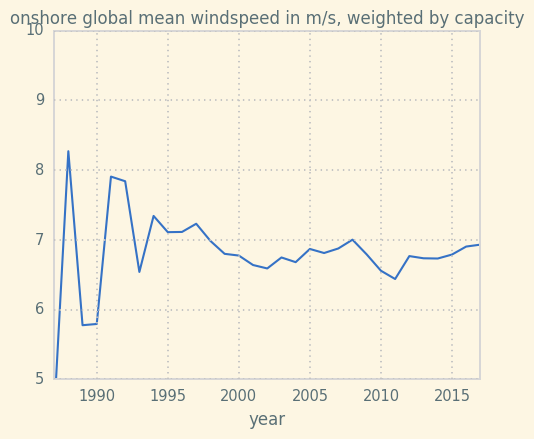

In [19]:
wd.loc['no'].groupby('year').apply(wavg).plot()
plt.xlim(1987,2017)
plt.ylim(5,10)
plt.title('onshore global mean windspeed in m/s, weighted by capacity')

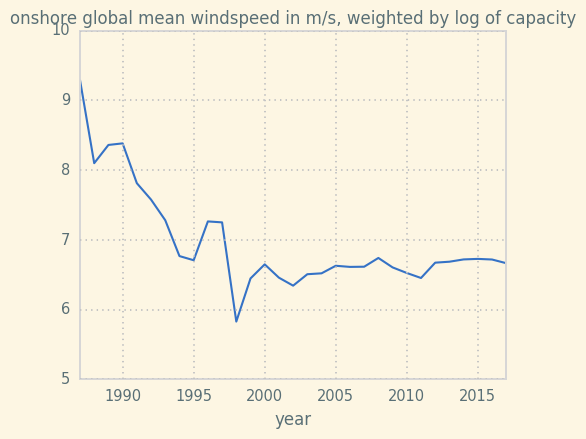

In [20]:
wd.loc['no'].groupby('year').apply(wavgl).plot()
plt.xlim(1987,2017)
plt.ylim(5,10)
plt.title('onshore global mean windspeed in m/s, weighted by log of capacity')

In [21]:
import statsmodels.formula.api as sm

In [22]:
R={}
for i in wd.set_index('ISO_CODE').index.unique():
    result = sm.ols(formula="year ~ power + wind", data=wd.set_index('ISO_CODE').loc[i]).fit()
    R[i]=result.params
P=pd.DataFrame(R).T
P[(P['Intercept']>1990)&(P['Intercept']<2020)]

,Intercept,power,wind
AR,2016.994046,0.430295,-2.230936
AT,1996.426233,0.138625,1.205219
AU,2010.186666,0.037711,-0.655714
BE,2013.994963,0.081233,-0.634146
BG,1996.908557,0.078605,1.044153
BR,2014.745642,0.042137,-0.294461
CA,2012.682228,0.012224,-0.500229
CH,1996.238058,0.585159,1.907646
CL,2014.799920,0.036791,-0.566838
CV,1993.231151,0.237205,1.325457


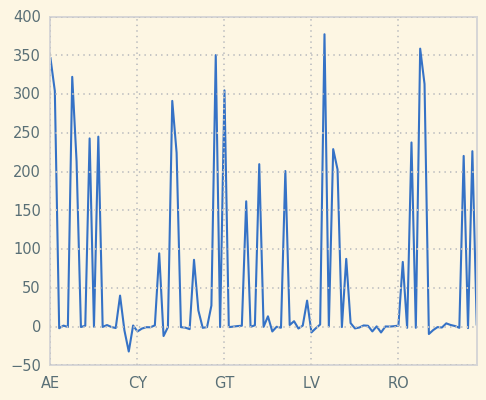

In [23]:
pd.DataFrame(R).T['wind'].plot()

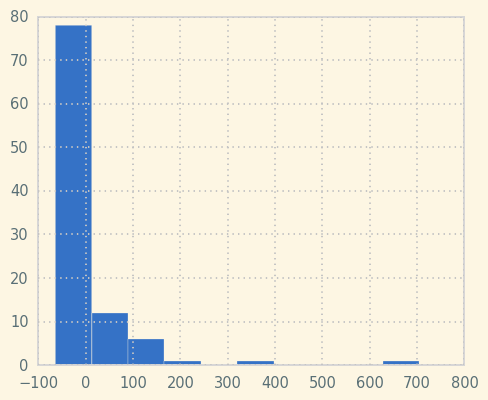

In [24]:
pd.DataFrame(R).T['power'].hist()#[r]['wind'] for r in r)

Resources

In [25]:
res=pd.read_json('../netset/json/res.json')

In [26]:
rw=res['res']['wind']
pw=res['inst']['wind']

In [27]:
rwc=pd.DataFrame(rw).set_index('country')
pwc=pd.DataFrame(pw).set_index('country')

In [28]:
rwc.drop('year',axis=1,inplace=True)

In [29]:
rwc.head()

,class,value
country,,
Canada,10,0.000000
Canada,9,19.923992
Canada,8,728.058334
Canada,7,1846.029342
Canada,6,1408.425171


In [30]:
pwc.head()

,class,value,year
country,,,
Canada,9,0.02124,1992
Canada,9,0.02124,1993
Canada,9,0.02124,1994
Canada,9,0.02124,1995
Canada,9,0.02232,1996


In [31]:
cnc=pd.read_csv('../universal/countries/cnc.csv').T[1:]

In [32]:
wd.set_index('ISO_CODE').loc['DE']

,NAME,OFFSHORE,Sub-national,wind,power,year,weighted,powerlog,windlog,smartyear,smartpowerlog,smartpower
ISO_CODE,,,,,,,,,,,,
DE,Hornisgrinde,no,Baden-Württemberg,6.231383,0.72,1994,0.185875,-0.142668,0.794584,1994.000000,-0.142668,0.72
DE,Kirchberg,no,Sachsen,6.672030,4.00,2006,1.105659,0.602060,0.824258,2006.000000,0.602060,4.00
DE,Kirchberg,no,Sachsen,6.672030,0.80,2001,0.221132,-0.096910,0.824258,2001.000000,-0.096910,0.80
DE,SchÃ¶ndelt,no,Nordrhein-Westfalen,5.490473,1.00,2003,0.227464,0.000000,0.739610,2003.000000,0.000000,1.00
DE,SchÃ¶ndelt,no,Nordrhein-Westfalen,5.490473,0.60,2003,0.136478,-0.221849,0.739610,2003.000000,-0.221849,0.60
DE,Kandrich,no,Rheinland-Pfalz,5.447010,18.00,2014,4.061943,1.255273,0.736158,2014.665639,1.255273,18.00
DE,Bernsbach,no,Sachsen,6.184990,0.30,1994,0.076871,-0.522879,0.791339,1994.000000,-0.522879,0.30
DE,Langenbrand,no,Baden-Württemberg,4.971233,0.75,1998,0.154464,-0.124939,0.696464,1998.000000,-0.124939,0.75
DE,Giesenhausen,no,Rheinland-Pfalz,5.473020,1.80,2003,0.408134,0.255273,0.738227,2003.617536,0.255273,1.80


In [33]:
for i in set(wd.set_index('ISO_CODE').index):
    if i not in cnc[0].values:
        print i
#all ok!

In [34]:
for i in set(rwc.index):
    if i not in set(cnc.index):
        print i

Libyan Arab Jamahiriya
Bosnia and Herzegovina
Russian Federation
Viet Nam
Iran (Islamic Republic of)
Syrian Arab Republic
Peru
United States of America
Brunei Darussalam
Republic of Moldova
Lao People's Democratic Republic
United Republic of Tanzania
Republic of Korea
Trinidad and Tobago
Myanmar
Democratic People's Republic of Korea


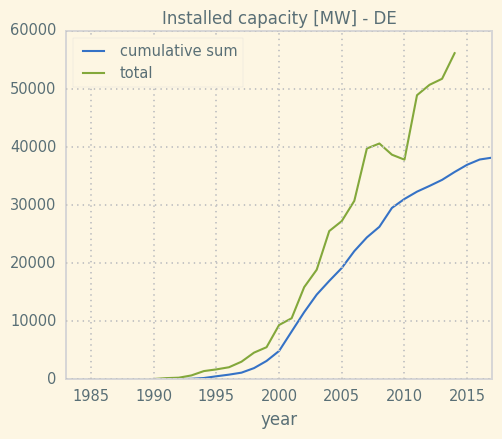

In [35]:
wd.set_index('ISO_CODE').loc['DE'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['Germany'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - DE')

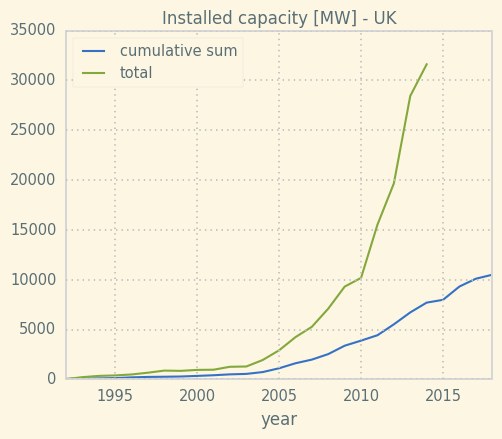

In [36]:
wd.set_index('ISO_CODE').loc['GB'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['United Kingdom'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - UK')

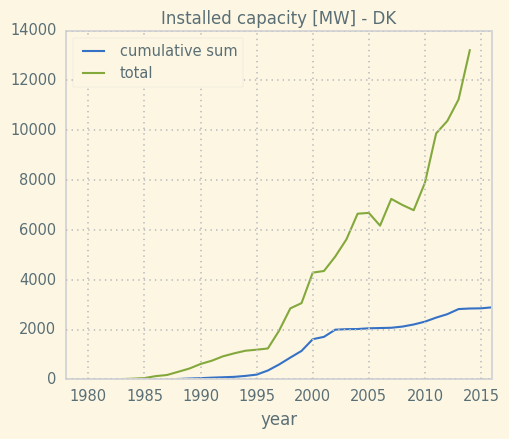

In [37]:
wd.set_index('ISO_CODE').loc['DK'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['Denmark'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - DK')

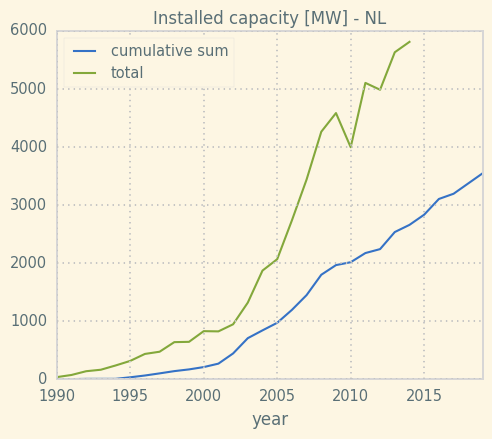

In [38]:
wd.set_index('ISO_CODE').loc['NL'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['Netherlands'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - NL')

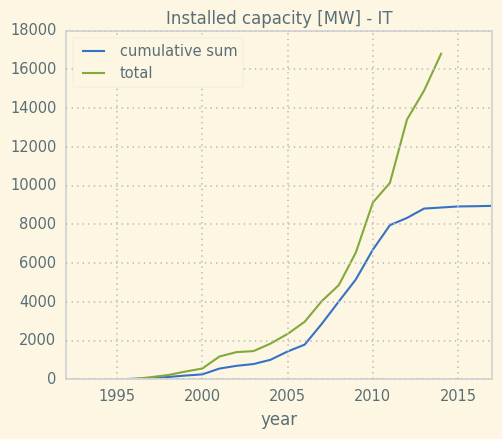

In [39]:
wd.set_index('ISO_CODE').loc['IT'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['Italy'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - IT')

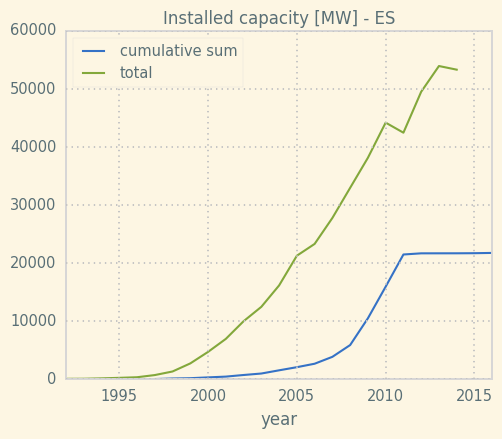

In [40]:
wd.set_index('ISO_CODE').loc['ES'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['Spain'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - ES')

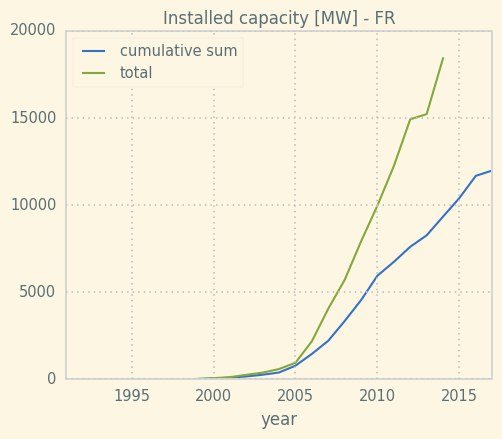

In [41]:
wd.set_index('ISO_CODE').loc['FR'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['France'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - FR')

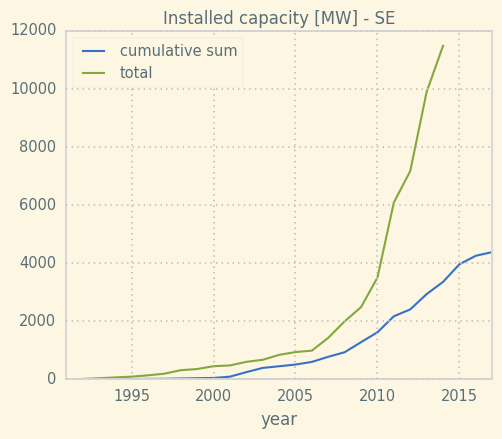

In [42]:
wd.set_index('ISO_CODE').loc['SE'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['Sweden'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - SE')

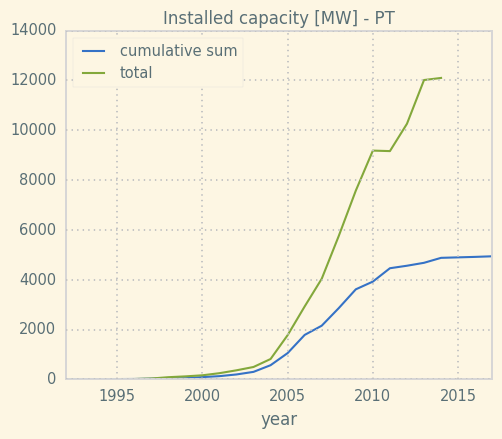

In [43]:
wd.set_index('ISO_CODE').loc['PT'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['Portugal'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - PT')

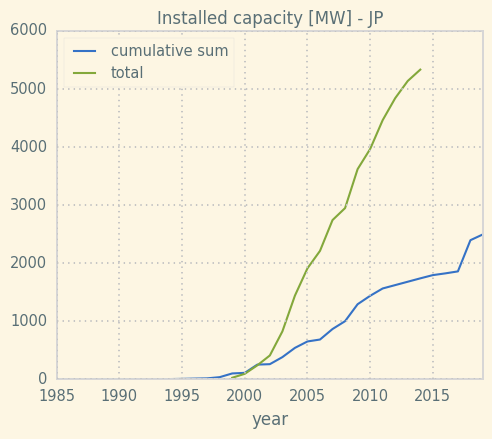

In [44]:
wd.set_index('ISO_CODE').loc['JP'].groupby('year').sum().cumsum()['power'].plot(label='cumulative sum')
(pwc.loc['Japan'].groupby('year').sum()['value']*1000).plot(label='total')
plt.legend(loc=0)
plt.title('Installed capacity [MW] - JP')

In [45]:
C={}
for i in wd.set_index('ISO_CODE').index.unique():
    C[i]=len(wd.set_index('ISO_CODE').loc[i].index)
C

{u'AE': 12,
 u'AM': 12,
 u'AR': 22,
 u'AT': 254,
 u'AU': 72,
 u'AZ': 2,
 u'BD': 2,
 u'BE': 207,
 u'BG': 67,
 u'BO': 2,
 u'BR': 406,
 u'BY': 2,
 u'CA': 242,
 u'CH': 19,
 u'CL': 33,
 u'CN': 717,
 u'CO': 12,
 u'CR': 12,
 u'CU': 4,
 u'CV': 5,
 u'CY': 5,
 u'CZ': 81,
 u'DE': 7344,
 u'DK': 1882,
 u'DO': 5,
 u'DZ': 12,
 u'EC': 3,
 u'EE': 28,
 u'EG': 8,
 u'ER': 12,
 u'ES': 1053,
 u'ET': 4,
 u'FI': 103,
 u'FJ': 12,
 u'FO': 3,
 u'FR': 1139,
 u'GB': 786,
 u'GE': 12,
 u'GM': 12,
 u'GR': 144,
 u'GT': 2,
 u'HN': 4,
 u'HR': 13,
 u'HU': 45,
 u'IE': 179,
 u'IL': 12,
 u'IN': 259,
 u'IR': 12,
 u'IS': 2,
 u'IT': 542,
 u'JM': 5,
 u'JO': 4,
 u'JP': 219,
 u'KE': 4,
 u'KN': 12,
 u'KR': 52,
 u'KZ': 12,
 u'LK': 17,
 u'LT': 30,
 u'LU': 19,
 u'LV': 10,
 u'MA': 16,
 u'ME': 12,
 u'MK': 2,
 u'MN': 5,
 u'MR': 2,
 u'MU': 2,
 u'MX': 45,
 u'NG': 12,
 u'NI': 2,
 u'NL': 613,
 u'NO': 31,
 u'NZ': 21,
 u'PA': 5,
 u'PE': 7,
 u'PH': 7,
 u'PK': 5,
 u'PL': 231,
 u'PR': 3,
 u'PT': 399,
 u'RO': 97,
 u'RS': 12,
 u'RU': 9,
 u'SA': 12

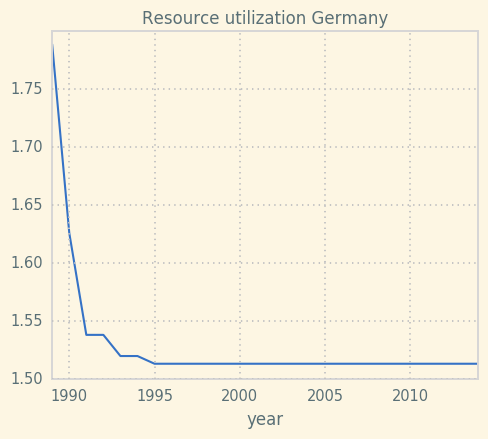

In [46]:
i='Germany'
rwc.loc[i]
resmean=np.average(rwc.loc[i]['class'],weights=rwc.loc[i]['value'])
grouped = pwc.loc[i].groupby('year')
def wavg(group):
    d = group['class']
    w = group['value']
    return (d * w).sum() / w.sum()
ru=grouped.apply(wavg)/resmean
ru.plot()
plt.title("Resource utilization "+i)

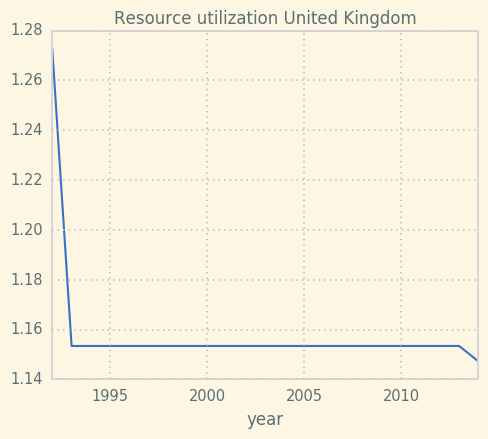

In [47]:
i='United Kingdom'
rwc.loc[i]
resmean=np.average(rwc.loc[i]['class'],weights=rwc.loc[i]['value'])
grouped = pwc.loc[i].groupby('year')
def wavg(group):
    d = group['class']
    w = group['value']
    return (d * w).sum() / w.sum()
ru=grouped.apply(wavg)/resmean
ru.plot()
plt.title("Resource utilization "+i)

In [74]:
wd.set_index('ISO_CODE').loc['ES']

,NAME,OFFSHORE,Sub-national,wind,power,year,weighted,powerlog,windlog,smartyear,smartpowerlog,smartpower
ISO_CODE,,,,,,,,,,,,
ES,Villoruebo,no,Castilla y León,7.565920,16.150,2008,5.062178,1.208173,0.878862,2008.837796,1.208173,16.150
ES,Somolinos,no,Castilla-La Mancha,6.686440,10.560,2007,2.925244,1.023664,0.825195,2007.827005,1.023664,10.560
ES,MasgalÃ¡n-Campo Do Coco,no,Galicia,6.769370,49.500,2011,13.882147,1.694605,0.830548,2011.502614,1.694605,49.500
ES,El Toranzo,no,Castilla y León,7.960730,19.800,2009,6.530121,1.296665,0.900953,2009.322584,1.296665,19.800
ES,Outes,no,Galicia,8.807060,35.070,2003,12.795872,1.544936,0.944831,2003.000000,1.544936,35.070
ES,Juno,no,Castilla y León,7.981230,49.500,2004,16.367344,1.694605,0.902070,2004.000000,1.694605,49.500
ES,Serra da Panda,no,Galicia,7.026130,18.480,2009,5.379245,1.266702,0.846716,2009.158437,1.266702,18.480
ES,Villamiel,no,Castilla y León,7.263140,17.850,2009,5.371132,1.251638,0.861124,2009.075914,1.251638,17.850
ES,Carba,no,Galicia,7.431900,19.800,2009,6.096327,1.296665,0.871100,2009.322584,1.296665,19.800


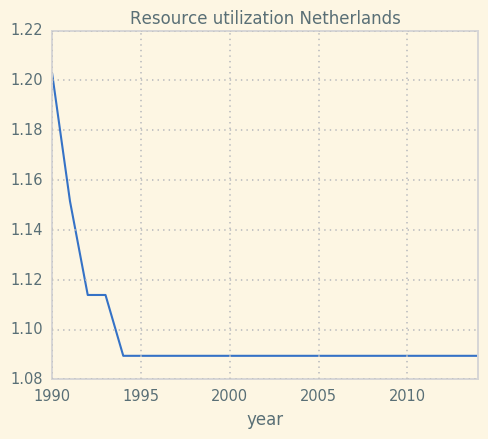

In [48]:
i='Netherlands'
rwc.loc[i]
resmean=np.average(rwc.loc[i]['class'],weights=rwc.loc[i]['value'])
grouped = pwc.loc[i].groupby('year')
def wavg(group):
    d = group['class']
    w = group['value']
    return (d * w).sum() / w.sum()
ru=grouped.apply(wavg)/resmean
ru.plot()
plt.title("Resource utilization "+i)

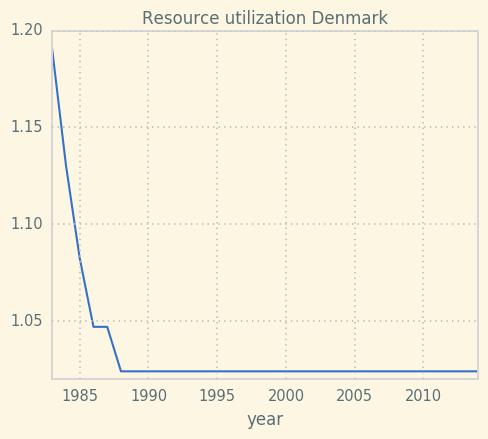

In [49]:
i='Denmark'
rwc.loc[i]
resmean=np.average(rwc.loc[i]['class'],weights=rwc.loc[i]['value'])
grouped = pwc.loc[i].groupby('year')
def wavg(group):
    d = group['class']
    w = group['value']
    return (d * w).sum() / w.sum()
ru=grouped.apply(wavg)/resmean
ru.plot()
plt.title("Resource utilization "+i)

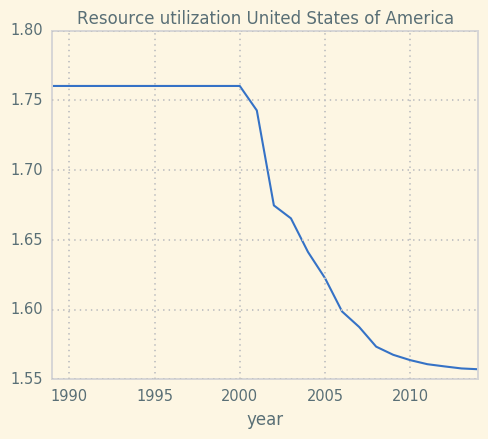

In [50]:
i='United States of America'
rwc.loc[i]
resmean=np.average(rwc.loc[i]['class'],weights=rwc.loc[i]['value'])
grouped = pwc.loc[i].groupby('year')
def wavg(group):
    d = group['class']
    w = group['value']
    return (d * w).sum() / w.sum()
ru=grouped.apply(wavg)/resmean
ru.plot()
plt.title("Resource utilization "+i)

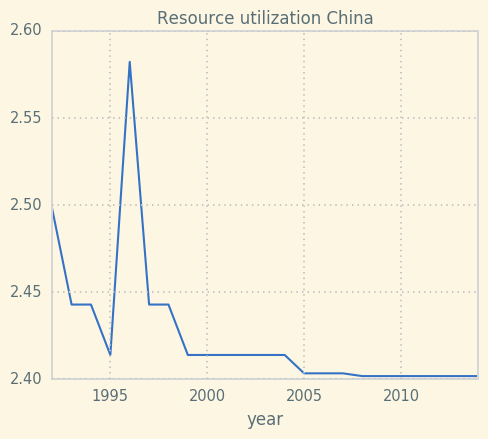

In [51]:
i='China'
rwc.loc[i]
resmean=np.average(rwc.loc[i]['class'],weights=rwc.loc[i]['value'])
grouped = pwc.loc[i].groupby('year')
def wavg(group):
    d = group['class']
    w = group['value']
    return (d * w).sum() / w.sum()
ru=grouped.apply(wavg)/resmean
ru.plot()
plt.title("Resource utilization "+i)

Regressions

In [52]:
R={}
for i in wd.set_index('ISO_CODE').index.unique():
    result = sm.ols(formula="year ~ power + wind", data=wd.set_index('ISO_CODE').loc[i]).fit()
    R[i]=result.params
P=pd.DataFrame(R).T
P[(P['Intercept']>1990)&(P['Intercept']<2020)]

,Intercept,power,wind
AR,2016.994046,0.430295,-2.230936
AT,1996.426233,0.138625,1.205219
AU,2010.186666,0.037711,-0.655714
BE,2013.994963,0.081233,-0.634146
BG,1996.908557,0.078605,1.044153
BR,2014.745642,0.042137,-0.294461
CA,2012.682228,0.012224,-0.500229
CH,1996.238058,0.585159,1.907646
CL,2014.799920,0.036791,-0.566838
CV,1993.231151,0.237205,1.325457


In [53]:
RU={}
for i in set(pwc.index):
    try:
        rwc.loc[i]
        resmean=np.average(rwc.loc[i]['class'],weights=rwc.loc[i]['value'])
        grouped = pwc.loc[i].groupby('year')
        def wavg(group):
            d = group['class']
            w = group['value']
            return (d * w).sum() / w.sum()
        j=cnc.loc[i][0]
        RU[j]=grouped.apply(wavg)/resmean
    except:
        pass

C:\Anaconda2\lib\site-packages\pandas\indexes\base.py:1237: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine
C:\Anaconda2\lib\site-packages\pandas\indexes\base.py:1945: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(key)


In [72]:
R={}
for i in ['DK','DE','GB']:
    df=wd.set_index('ISO_CODE').loc[i]
    z=[]
    for j in df.T.iteritems():
        yr=int(np.round(j[1][9]))
        try:
            z.append(RU[i][yr])
        except:
            z.append(1)
    df['ru']=z
    result = sm.ols(formula="year ~ power + wind", data=df).fit()
    R[i]=result.params
P=pd.DataFrame(R).T
P[(P['Intercept']>1990)&(P['Intercept']<2020)]

,Intercept,power,wind
DE,2007.277386,0.273320,-0.859214
DK,2003.657478,1.032827,-0.966523
GB,2016.466179,0.008736,-0.748899


In [65]:
df

,NAME,OFFSHORE,Sub-national,wind,power,year,weighted,powerlog,windlog,smartyear,smartpowerlog,smartpower,ru
ISO_CODE,,,,,,,,,,,,,
DK,Rutsker,no,Bornholm,8.901220,0.675,1992,0.248918,-0.170696,0.949450,1992.248520,-0.170696,0.675,1.024133
DK,Rutsker,no,Bornholm,8.901220,0.660,1999,0.243387,-0.180456,0.949450,1999.832877,-0.180456,0.660,1.024133
DK,Rutsker,no,Bornholm,8.901220,3.900,2002,1.438193,0.591065,0.949450,2002.915068,0.591065,3.900,1.024133
DK,Rutsker,no,Bornholm,8.901220,5.250,2006,1.936030,0.720159,0.949450,2006.246461,0.720159,5.250,1.024133
DK,Sorring,no,Århus,7.397290,0.150,1992,0.045969,-0.823909,0.869073,1992.833333,-0.823909,0.150,1.024133
DK,Bringstrup,no,Vestsjælland,7.144193,0.660,1998,0.195344,-0.180456,0.853953,1998.915068,-0.180456,0.660,1.024133
DK,Bringstrup,no,Vestsjælland,7.144193,0.200,1988,0.059195,-0.698970,0.853953,1988.915301,-0.698970,0.200,1.024133
DK,Anderup,no,South Jutland,7.491193,0.660,2002,0.204832,-0.180456,0.874551,2002.246461,-0.180456,0.660,1.024133
DK,Anderup,no,South Jutland,7.491193,0.660,1999,0.204832,-0.180456,0.874551,1999.915068,-0.180456,0.660,1.024133


In [57]:
z=[]
i='RO'
for j in df.T.iteritems():
        yr=int(np.round(j[1][9]))
        try:
            z.append(RU[i][yr])
        except:
            z.append(np.nan)
        print yr

1992
2000
2003
2006
1993
1999
1989
2002
2000
1999
1999
1996
1998
1999
1994
1994
1997
2004
2008
2001
2001
2000
1990
1990
1996
1990
1994
1989
1997
1992
1995
1997
1997
1997
1997
1996
1999
1988
1997
1993
1994
2000
1991
2001
2001
2000
2000
2000
2002
2001
2001
2003
1999
2000
2000
1994
1999
2001
1993
1991
1991
1989
1989
1998
1991
1999
1992
1991
1990
2001
2000
2000
1998
1998
1999
1998
1991
2001
2001
1997
1997
1999
1995
1994
1991
1992
1996
1999
1997
2000
2003
2001
2001
1999
1999
2000
2000
1991
1997
1992
2000
1993
2000
1991
1998
2000
1998
1999
2001
2000
1998
2001
1989
2000
1988
2010
2000
1996
1996
1991
1991
1993
2000
1999
1989
1988
1997
1996
2000
1998
1998
1988
1991
1998
2000
2000
2000
1998
2009
2000
2000
2000
1991
1997
1997
1997
1997
1996
1989
1997
1997
1997
2003
2001
2003
2011
2011
2000
1997
2000
2001
2000
2004
2001
1998
1998
1998
1998
1999
1997
1998
1998
2000
1997
2003
1989
1992
1999
2001
2000
1989
2001
1999
1997
1998
1999
1999
1999
2000
1999
1989
1999
2003
1987
2012
2000
2013
2000
2001
1992


In [105]:
z

[1.0241329167914253,
 1.0241329167914248,
 1.0241329167914248,
 1.0241329167914248,
 1.0241329167914253,
 1.024132916791425,
 1.0241329167914262,
 1.024132916791425,
 1.0241329167914248,
 1.024132916791425,
 1.024132916791425,
 1.0241329167914253,
 1.0241329167914248,
 1.024132916791425,
 1.0241329167914253,
 1.0241329167914253,
 1.0241329167914248,
 1.0241329167914248,
 1.0241329167914248,
 1.0241329167914253,
 1.0241329167914253,
 1.0241329167914248,
 1.0241329167914253,
 1.0241329167914253,
 1.0241329167914253,
 1.0241329167914253,
 1.0241329167914253,
 1.0241329167914262,
 1.0241329167914248,
 1.0241329167914253,
 1.0241329167914253,
 1.0241329167914248,
 1.0241329167914248,
 1.0241329167914248,
 1.0241329167914248,
 1.0241329167914253,
 1.024132916791425,
 1.0241329167914262,
 1.0241329167914248,
 1.0241329167914253,
 1.0241329167914253,
 1.0241329167914248,
 1.0241329167914255,
 1.0241329167914253,
 1.0241329167914253,
 1.0241329167914248,
 1.0241329167914248,
 1.0241329167914248

In [104]:
df

,NAME,OFFSHORE,Sub-national,wind,power,year,weighted,powerlog,windlog,smartyear,smartpowerlog,smartpower,ru
ISO_CODE,,,,,,,,,,,,,
DK,Rutsker,no,Bornholm,8.901220,0.675,1992,0.248918,-0.170696,0.949450,1992.248520,-0.170696,0.675,1.024133
DK,Rutsker,no,Bornholm,8.901220,0.660,1999,0.243387,-0.180456,0.949450,1999.832877,-0.180456,0.660,1.024133
DK,Rutsker,no,Bornholm,8.901220,3.900,2002,1.438193,0.591065,0.949450,2002.915068,0.591065,3.900,1.024133
DK,Rutsker,no,Bornholm,8.901220,5.250,2006,1.936030,0.720159,0.949450,2006.246461,0.720159,5.250,1.024133
DK,Sorring,no,Århus,7.397290,0.150,1992,0.045969,-0.823909,0.869073,1992.833333,-0.823909,0.150,1.024133
DK,Bringstrup,no,Vestsjælland,7.144193,0.660,1998,0.195344,-0.180456,0.853953,1998.915068,-0.180456,0.660,1.024133
DK,Bringstrup,no,Vestsjælland,7.144193,0.200,1988,0.059195,-0.698970,0.853953,1988.915301,-0.698970,0.200,1.024133
DK,Anderup,no,South Jutland,7.491193,0.660,2002,0.204832,-0.180456,0.874551,2002.246461,-0.180456,0.660,1.024133
DK,Anderup,no,South Jutland,7.491193,0.660,1999,0.204832,-0.180456,0.874551,1999.915068,-0.180456,0.660,1.024133
